## Inicializando

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#!python -m venv pykan-env
#!source pykan-env/Scripts/activate  # No Windows use `pykan-env\Scripts\activate`

In [ ]:
!pip install pykan==0.2.2

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.metrics import confusion_matrix, roc_curve, auc
import seaborn as sns
import torch
from kan import KAN
import matplotlib.pyplot as plt
import numpy as np

# Caminho para o arquivo no Google Drive
file_path = '/content/drive/My Drive/python/train.csv'

# Ler o arquivo usando pandas
df = pd.read_csv(file_path)


In [ ]:
# Mostrar as primeiras linhas do dataframe
df.head()

,Unnamed: 0,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,0,70172,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,...,5,4,3,4,4,5,5,25,18.0,neutral or dissatisfied
1,1,5047,Male,disloyal Customer,25,Business travel,Business,235,3,2,...,1,1,5,3,1,4,1,1,6.0,neutral or dissatisfied
2,2,110028,Female,Loyal Customer,26,Business travel,Business,1142,2,2,...,5,4,3,4,4,4,5,0,0.0,satisfied
3,3,24026,Female,Loyal Customer,25,Business travel,Business,562,2,5,...,2,2,5,3,1,4,2,11,9.0,neutral or dissatisfied
4,4,119299,Male,Loyal Customer,61,Business travel,Business,214,3,3,...,3,3,4,4,3,3,3,0,0.0,satisfied


In [ ]:
print(df.columns)


Index(['Unnamed: 0', 'id', 'Gender', 'Customer Type', 'Age', 'Type of Travel',
       'Class', 'Flight Distance', 'Inflight wifi service',
       'Departure/Arrival time convenient', 'Ease of Online booking',
       'Gate location', 'Food and drink', 'Online boarding', 'Seat comfort',
       'Inflight entertainment', 'On-board service', 'Leg room service',
       'Baggage handling', 'Checkin service', 'Inflight service',
       'Cleanliness', 'Departure Delay in Minutes', 'Arrival Delay in Minutes',
       'satisfaction'],
      dtype='object')


Dropando as colunas que não trazem nenhuma informação

In [ ]:
df = df.drop('Unnamed: 0', axis=1)
df = df.drop('id', axis=1)

In [ ]:
colunas_categoricas = [0, 1, 3, 4]

ordinal_columns = list(range(6, 20))

In [ ]:
for col in colunas_categoricas:
  df[df.columns[col]] = df[df.columns[col]].astype('category')


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103904 entries, 0 to 103903
Data columns (total 23 columns):
 #   Column                             Non-Null Count   Dtype   
---  ------                             --------------   -----   
 0   Gender                             103904 non-null  category
 1   Customer Type                      103904 non-null  category
 2   Age                                103904 non-null  int64   
 3   Type of Travel                     103904 non-null  category
 4   Class                              103904 non-null  category
 5   Flight Distance                    103904 non-null  int64   
 6   Inflight wifi service              103904 non-null  int64   
 7   Departure/Arrival time convenient  103904 non-null  int64   
 8   Ease of Online booking             103904 non-null  int64   
 9   Gate location                      103904 non-null  int64   
 10  Food and drink                     103904 non-null  int64   
 11  Online boarding           

In [ ]:
corr_mat =df.corr(numeric_only=True)

<Axes: >

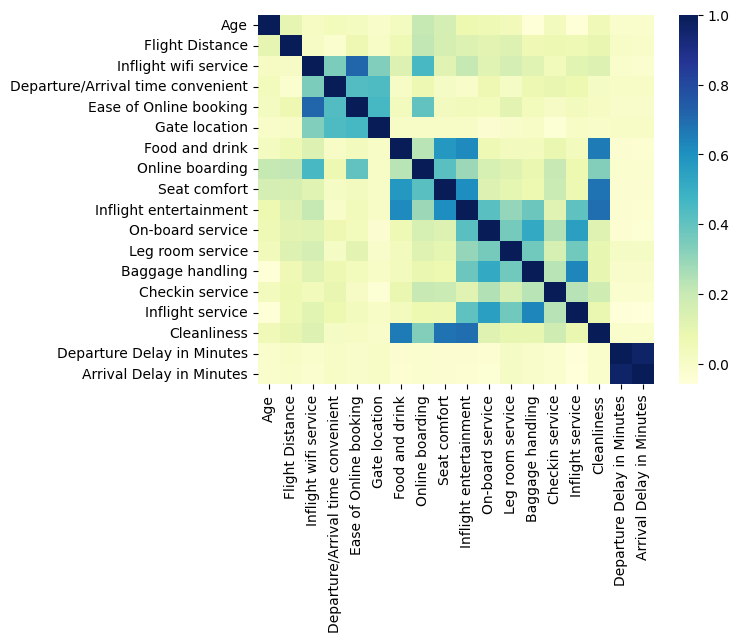

In [ ]:
sns.heatmap(corr_mat, cmap="YlGnBu")



In [ ]:
df.isnull().sum()

,0
Gender,0
Customer Type,0
Age,0
Type of Travel,0
Class,0
Flight Distance,0
Inflight wifi service,0
Departure/Arrival time convenient,0
Ease of Online booking,0
Gate location,0


A única coluna que apresenta campos faltantes é a coluna `Arrival Delay in Minutes`. Como foi observado anteriormente, ela tem uma alta correlação com a coluna `Departure Delay in Minutes`. Devido a isso, decidimos remover uma delas, e como `Arrival Delay in Minutes` possui campos vazios, optamos por removê-la.

In [ ]:
df.drop('Arrival Delay in Minutes', axis=1, inplace=True)

In [ ]:
distribuicao = df['satisfaction'].value_counts();
print(distribuicao)

satisfaction
neutral or dissatisfied    58879
satisfied                  45025
Name: count, dtype: int64


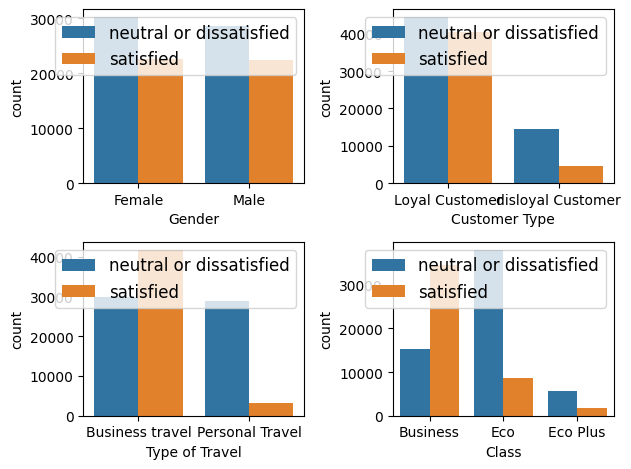

In [ ]:

fig, axs = plt.subplots(nrows=2, ncols=2)


# Flatten the axs array to easily access each subplot
axs = axs.ravel()

for i, col in enumerate(colunas_categoricas):
    sns.countplot(x=df.columns[col], hue='satisfaction', data=df, ax=axs[i])
    axs[i].legend(loc='upper right', fontsize=12)  # Add legend for each subplot

plt.tight_layout()
plt.show()

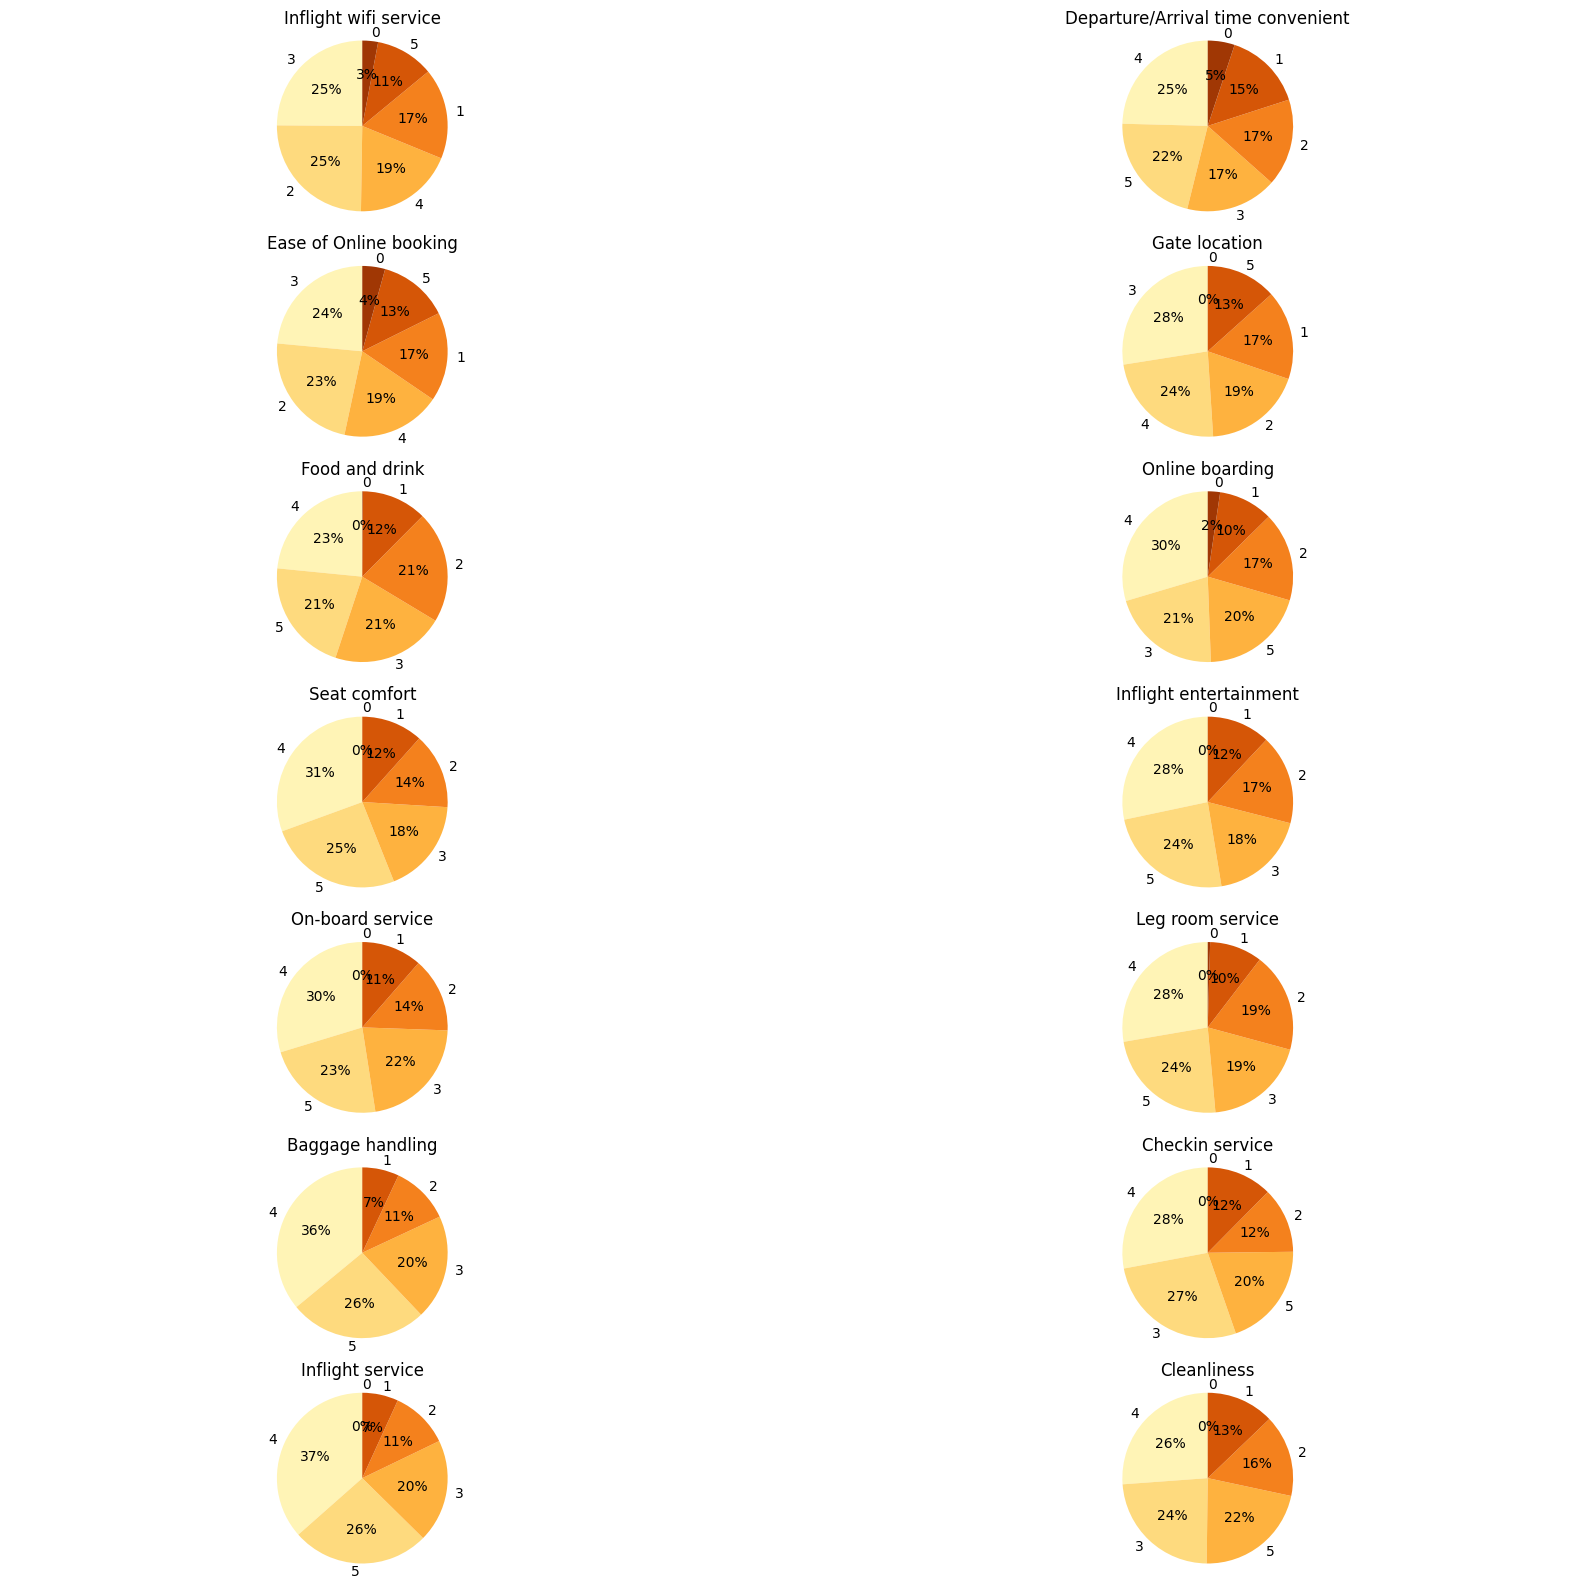

In [ ]:
categ = df.iloc[:,ordinal_columns]
fig, axes = plt.subplots(7, 2, figsize = (20, 20))
for i, col in enumerate(categ):
    column_values = df[col].value_counts()
    labels = column_values.index
    sizes = column_values.values
    axes[i//2, i%2].pie(sizes, labels = labels, colors = sns.color_palette("YlOrBr"), autopct = '%1.0f%%', startangle = 90)
    axes[i//2, i%2].axis('equal')
    axes[i//2, i%2].set_title(col)
plt.show()

Desses gráficos temos alguns pontos interessantes:


*   Homens e mulheres tem níveis de satisfação parecidos
*   Passageiros leais ficam menos insatisfeitos do que passageiros não leais
*   Passageiros na classe econômica estão mais insatisfeitos do que passageiros da classe executiva
*   Mais de 60% dos passageiros ficaram satisfeitos com o serviço de transporte de bagagem e serviço em voo (classificado de 4 a 5 em 5)
*  Mais de 50% dos passageiros estão satisfeitos com serviços de bordo, leg room service, entreterimento em voo e com o conforto dos assentos


## Analisando os dados numéricos

### Flight Distance


<ipython-input-19-1c116a5034bf>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x = "satisfaction", y = "Flight Distance", palette = "YlOrBr", data = df, ax = ax[0])


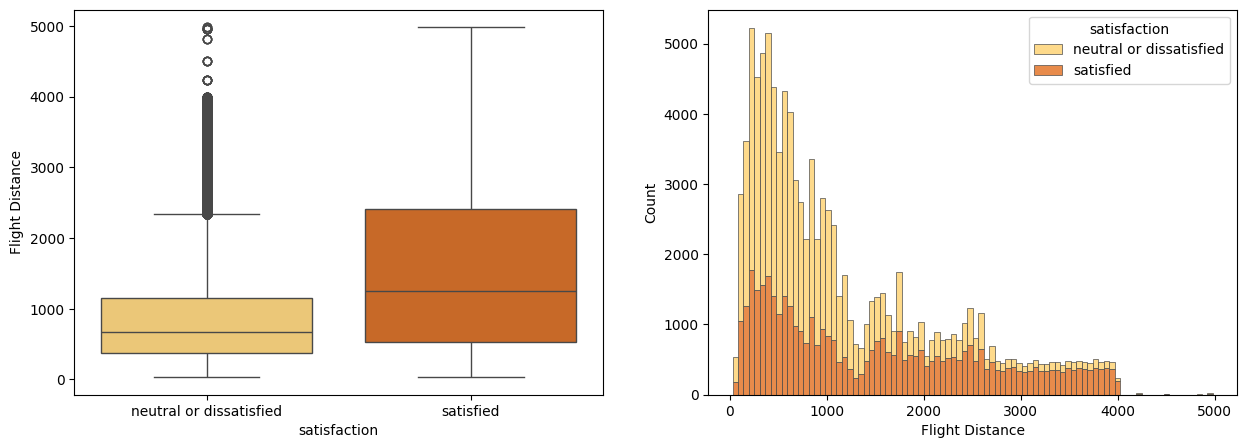

In [ ]:
f, ax = plt.subplots(1, 2, figsize = (15,5))
sns.boxplot(x = "satisfaction", y = "Flight Distance", palette = "YlOrBr", data = df, ax = ax[0])
sns.histplot(data=df, x = "Flight Distance", hue = "satisfaction", multiple = "stack", palette = "YlOrBr", edgecolor = ".3", linewidth = .5, ax = ax[1])
pass

In [ ]:
# Calcular o IQR para a coluna
Q1 = df["Flight Distance"].quantile(0.25)
Q3 = df["Flight Distance"].quantile(0.75)
IQR = Q3 - Q1

# Definir os limites superior e inferior para detectar outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identificar outliers
outliers = df[(df["Flight Distance"] < lower_bound) | (df["Flight Distance"] > upper_bound)]

print(outliers.shape)

(2291, 22)


In [ ]:
# removendo outliers
df = df[(df['Flight Distance'] >= lower_bound) & (df['Flight Distance'] <= upper_bound)]

### Age

<ipython-input-22-225adf5fa614>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x = "satisfaction", y = "Age", palette = "YlOrBr", data = df, ax = ax[0])


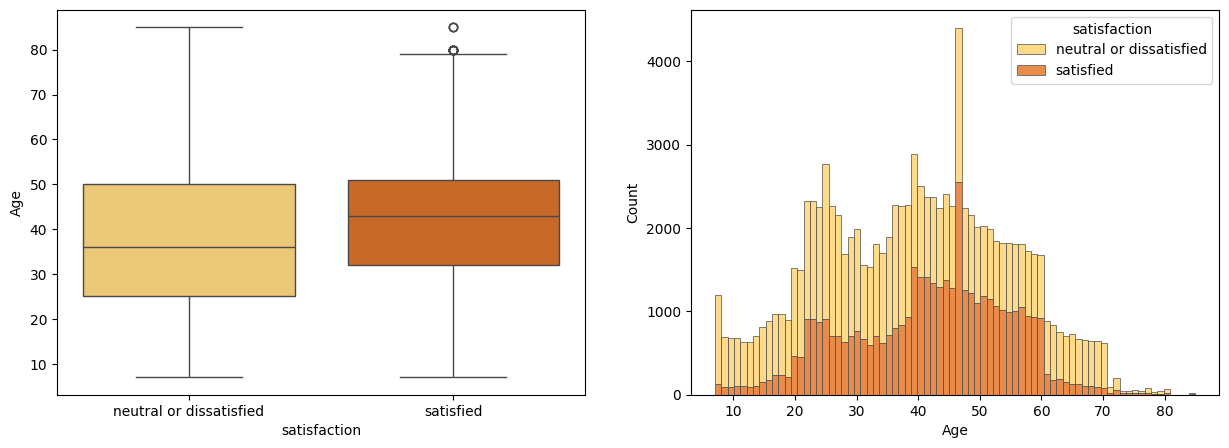

In [ ]:
f, ax = plt.subplots(1, 2, figsize = (15,5))
sns.boxplot(x = "satisfaction", y = "Age", palette = "YlOrBr", data = df, ax = ax[0])
sns.histplot(data=df, x = "Age", hue = "satisfaction", multiple = "stack", palette = "YlOrBr", edgecolor = ".3", linewidth = .5, ax = ax[1])
pass

In [ ]:
# Calcular o IQR para a coluna
Q1 = df["Age"].quantile(0.25)
Q3 = df["Age"].quantile(0.75)
IQR = Q3 - Q1

# Definir os limites superior e inferior para detectar outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identificar outliers
outliers = df[(df["Age"] < lower_bound) | (df["Age"] > upper_bound)]

print(outliers.shape)

(0, 22)


### Departure Delay in Minutes

In [ ]:
df['Departure Delay in Minutes'].describe()


,Departure Delay in Minutes
count,101613.000000
mean,14.799150
std,38.179992
min,0.000000
25%,0.000000
50%,0.000000
75%,12.000000
max,1592.000000


**Distribuição dos Dados:** A mediana (50%) e o primeiro quartil (25%) são ambos 0, indicando que pelo menos metade dos voos não teve nenhum atraso de partida. Isso sugere que os dados são altamente assimétricos, com muitos valores sendo 0 e uma longa cauda de valores maiores.

**Outliers:** O valor máximo é 1592, o que é significativamente maior que a média e os quartis. Isso indica a presença de outliers, que podem afetar a performance de alguns modelos de machine learning.

Para lidar com a alta assimetria, foi aplicado uma **transformação logarítmica**

In [ ]:
df['Departure Delay in Minutes'] = np.log1p(df['Departure Delay in Minutes'])

In [ ]:
# Calcular o IQR para a coluna
Q1 = df["Departure Delay in Minutes"].quantile(0.25)
Q3 = df["Departure Delay in Minutes"].quantile(0.75)
IQR = Q3 - Q1

# Definir os limites superior e inferior para detectar outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identificar outliers
outliers = df[(df["Departure Delay in Minutes"] < lower_bound) | (df["Departure Delay in Minutes"] > upper_bound)]

print(outliers.shape)

(17, 22)


In [ ]:
# removendo outliers
df = df[(df['Departure Delay in Minutes'] >= lower_bound) & (df['Departure Delay in Minutes'] <= upper_bound)]

### Normalizando com MINMAX Scaler


In [ ]:
numerical_columns = ['Age', 'Flight Distance', 'Departure Delay in Minutes']

In [ ]:
numerical_columns

['Age', 'Flight Distance', 'Departure Delay in Minutes']

In [ ]:
scaler = MinMaxScaler()
df[numerical_columns] = scaler.fit_transform(df[numerical_columns])

## Lidando com dados categoricos

In [ ]:
categorical_columns = [c for c in df.columns if df[c].dtype.name == 'category']

In [ ]:
data_categorical = pd.get_dummies(df[categorical_columns]).astype(int)

## Montando a base de dados e separando conjuntos de treinamento e validação

In [ ]:
data = pd.concat([df[numerical_columns], data_categorical, df.iloc[:,ordinal_columns]], axis=1)

In [ ]:
data.describe()

,Age,Flight Distance,Departure Delay in Minutes,Gender_Female,Gender_Male,Customer Type_Loyal Customer,Customer Type_disloyal Customer,Type of Travel_Business travel,Type of Travel_Personal Travel,Class_Business,...,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness
count,101596.000000,101596.000000,101596.000000,101596.000000,101596.000000,101596.000000,101596.000000,101596.000000,101596.000000,101596.000000,...,101596.000000,101596.000000,101596.000000,101596.000000,101596.000000,101596.000000,101596.000000,101596.000000,101596.000000,101596.000000
mean,0.413966,0.296243,0.192928,0.507451,0.492549,0.813329,0.186671,0.682989,0.317011,0.466672,...,3.198403,3.236151,3.429141,3.348577,3.375399,3.342494,3.628115,3.300238,3.637131,3.280493
std,0.194403,0.248616,0.252929,0.499947,0.499947,0.389649,0.389649,0.465314,0.465314,0.498890,...,1.330897,1.351397,1.322145,1.335466,1.289677,1.316960,1.181678,1.266540,1.176515,1.314166
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,0.256410,0.101484,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,3.000000,3.000000,3.000000,2.000000
50%,0.423077,0.211336,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,...,3.000000,3.000000,4.000000,4.000000,4.000000,4.000000,4.000000,3.000000,4.000000,3.000000
75%,0.564103,0.439676,0.400861,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,...,4.000000,4.000000,5.000000,4.000000,4.000000,4.000000,5.000000,4.000000,5.000000,4.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000


In [ ]:
target = df['satisfaction']

In [ ]:
print(data.shape)

(101596, 26)


In [ ]:
X_train = data
y_train = target
N, d = X_train.shape
N, d

(101596, 26)

## Lidando com a base de teste


In [ ]:
# Caminho para o arquivo no Google Drive
file_path_test = '/content/drive/My Drive/python/test.csv'

# Ler o arquivo usando pandas
df_test = pd.read_csv(file_path_test)

In [ ]:
print(df_test.columns)

Index(['Unnamed: 0', 'id', 'Gender', 'Customer Type', 'Age', 'Type of Travel',
       'Class', 'Flight Distance', 'Inflight wifi service',
       'Departure/Arrival time convenient', 'Ease of Online booking',
       'Gate location', 'Food and drink', 'Online boarding', 'Seat comfort',
       'Inflight entertainment', 'On-board service', 'Leg room service',
       'Baggage handling', 'Checkin service', 'Inflight service',
       'Cleanliness', 'Departure Delay in Minutes', 'Arrival Delay in Minutes',
       'satisfaction'],
      dtype='object')


In [ ]:
df_test = df_test.drop('Unnamed: 0', axis=1)
df_test = df_test.drop('id', axis=1)

In [ ]:
for col in colunas_categoricas:
  df_test[df_test.columns[col]] = df_test[df_test.columns[col]].astype('category')

In [ ]:
df_test.drop('Arrival Delay in Minutes', axis=1, inplace=True)

In [ ]:
df_test[numerical_columns] = scaler.fit_transform(df_test[numerical_columns])

In [ ]:
test_categorical_data = pd.get_dummies(df_test[categorical_columns]).astype(int)

In [ ]:
data_test = pd.concat([df_test[numerical_columns], test_categorical_data, df_test.iloc[:,ordinal_columns]], axis=1)

In [ ]:
data_test.describe()

,Age,Flight Distance,Departure Delay in Minutes,Gender_Female,Gender_Male,Customer Type_Loyal Customer,Customer Type_disloyal Customer,Type of Travel_Business travel,Type of Travel_Personal Travel,Class_Business,...,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness
count,25976.000000,25976.000000,25976.000000,25976.000000,25976.000000,25976.000000,25976.000000,25976.000000,25976.000000,25976.000000,...,25976.000000,25976.000000,25976.000000,25976.000000,25976.000000,25976.000000,25976.000000,25976.000000,25976.000000,25976.000000
mean,0.418217,0.234812,0.012683,0.507083,0.492917,0.815253,0.184747,0.694410,0.305590,0.481021,...,3.215353,3.261665,3.449222,3.357753,3.385664,3.350169,3.633238,3.314175,3.649253,3.286226
std,0.194047,0.201673,0.033177,0.499959,0.499959,0.388100,0.388100,0.460666,0.460666,0.499649,...,1.331506,1.355536,1.320090,1.338299,1.282088,1.318862,1.176525,1.269332,1.180681,1.319330
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
25%,0.256410,0.077342,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,3.000000,3.000000,3.000000,2.000000
50%,0.423077,0.165186,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,...,3.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,3.000000,4.000000,3.000000
75%,0.564103,0.345921,0.010638,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,...,4.000000,4.000000,5.000000,4.000000,4.000000,4.000000,5.000000,4.000000,5.000000,4.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000


In [ ]:
X_test = data_test
y_test = df_test['satisfaction']

## KAN


In [ ]:
scaler = StandardScaler()
X_trainn = scaler.fit_transform(X_train)
X_testt = scaler.transform(X_test)

In [ ]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_test = encoder.fit_transform(y_test)

In [ ]:
train_input = torch.tensor(X_trainn, dtype=torch.float32)
train_label = torch.tensor(y_train, dtype=torch.long)
test_input = torch.tensor(X_testt, dtype=torch.float32)
test_label = torch.tensor(y_test, dtype=torch.long)

In [ ]:
dataset = {
    'train_input': train_input,
    'train_label': train_label,
    'test_input': test_input,
    'test_label': test_label
}

In [ ]:
model = KAN(width=[X_train.shape[1], 2], grid=3, k=3)

checkpoint directory created: ./model
saving model version 0.0


In [ ]:
def train_acc():
    return torch.mean((torch.argmax(model(dataset['train_input']), dim=1) == dataset['train_label']).float())

def test_acc():
    return torch.mean((torch.argmax(model(dataset['test_input']), dim=1) == dataset['test_label']).float())

In [ ]:
results = model.fit(dataset, opt="LBFGS", steps=1f0, metrics=(train_acc, test_acc), loss_fn=torch.nn.CrossEntropyLoss())

| train_loss: 4.21e-01 | test_loss: 4.26e-01 | reg: 0.00e+00 | : 100%|█| 10/10 [09:52<00:00, 59.22s/

saving model version 0.1


In [ ]:
# Obter a acurácia final
final_train_acc = results['train_acc'][-1]
final_test_acc = results['test_acc'][-1]

print(f"Acurácia final no conjunto de treino: {final_train_acc:.4f}")
print(f"Acurácia final no conjunto de teste: {final_test_acc:.4f}")

Acurácia final no conjunto de treino: 0.9339
Acurácia final no conjunto de teste: 0.9331


###Grid-search


Para realizar o Grid-Search com a KAN, começaremos definindo uma função para realizar o treinamento.

In [ ]:
def train_and_evaluate_model(width, grid, k, steps):
    model = KAN(width=width, grid=grid, k=k)

    # Funções de avaliação
    def train_acc():
        return torch.mean((torch.argmax(model(dataset['train_input']), dim=1) == dataset['train_label']).float())

    def test_acc():
        return torch.mean((torch.argmax(model(dataset['test_input']), dim=1) == dataset['test_label']).float())

    results = model.fit(dataset, opt="LBFGS", steps=steps, metrics=(train_acc, test_acc), loss_fn=torch.nn.CrossEntropyLoss())
    final_train_acc = results['train_acc'][-1]
    final_test_acc = results['test_acc'][-1]
    return train_acc, test_acc

In [ ]:
param_grid = {
    'width': [[X_train.shape[1], 2], [X_train.shape[1], 4]],
    'grid': [2, 3],
    'k': [5, 8],
    'steps': [10,14]
}

Inicializando e treinando a rede com as combinação do grid

In [ ]:
best_params = None
best_accuracy = 0

# Iterar sobre todas as combinações de hiperparâmetros
for width in param_grid['width']:
    for grid in param_grid['grid']:
        for k in param_grid['k']:
            for steps in param_grid['steps']:
                train_acc, test_acc = train_and_evaluate_model(width, grid, k, steps)
                print(f"Width: {width}, Grid: {grid}, K: {k}, Steps: {steps}, Train Acc: {train_acc():.4f}, Test Acc: {test_acc():.4f}")

                if test_acc() > best_accuracy:
                    best_accuracy = test_acc()
                    best_params = {'width': width, 'grid': grid, 'k': k, 'steps': steps}

checkpoint directory created: ./model
saving model version 0.0


| train_loss: 4.25e-01 | test_loss: 4.30e-01 | reg: 1.07e+01 | : 100%|█| 10/10 [21:37<00:00, 129.74s


saving model version 0.1
Width: [[26, 0], [2, 0]], Grid: 2, K: 5, Steps: 10, Train Acc: 0.9336, Test Acc: 0.9329
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 4.24e-01 | test_loss: 4.29e-01 | reg: 1.10e+01 | : 100%|█| 14/14 [28:32<00:00, 122.32s


saving model version 0.1
Width: [[26, 0], [2, 0]], Grid: 2, K: 5, Steps: 14, Train Acc: 0.9340, Test Acc: 0.9326
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 4.30e-01 | test_loss: 4.35e-01 | reg: 7.84e+00 | : 100%|█| 10/10 [38:49<00:00, 232.97s


saving model version 0.1
Width: [[26, 0], [2, 0]], Grid: 2, K: 8, Steps: 10, Train Acc: 0.9319, Test Acc: 0.9327
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 4.35e-01 | test_loss: 4.38e-01 | reg: 0.00e+00 | :  50%|▌| 7/14 [29:09<29:43, 254.72s/

# Melhores parametros

In [ ]:
print(f"Best parameters: {best_params}")
print(f"Best test accuracy: {best_accuracy:.4f}")

In [ ]:
final_model = KAN(width=best_params['width'], grid=best_params['grid'], k=best_params['k'])
results = final_model.fit(dataset, opt="LBFGS", steps=best_params['steps'], metrics=(train_acc, test_acc), loss_fn=torch.nn.CrossEntropyLoss())


Visualizando modelo e resultados

In [ ]:
def train_acc():
    return torch.mean((torch.argmax(final_model(dataset['train_input']), dim=1) == dataset['train_label']).float())

def test_acc():
    return torch.mean((torch.argmax(final_model(dataset['test_input']), dim=1) == dataset['test_label']).float())

In [ ]:
final_train_acc = results['train_acc'][-1]
final_test_acc = results['test_acc'][-1]

print(f"Acurácia final no conjunto de treino: {final_train_acc:.4f}")
print(f"Acurácia final no conjunto de teste: {final_test_acc:.4f}")

## Plot train e test accuracy

In [ ]:
plt.plot(results['train_acc'], label='Train Accuracy')
plt.plot(results['test_acc'], label='Test Accuracy')
plt.xlabel('Steps')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
test_outputs = final_model(dataset['test_input'])
test_predictions = torch.argmax(test_outputs, dim=1).numpy()

conf_matrix = confusion_matrix(y_test, test_predictions)
conf_matrix_percent = conf_matrix / conf_matrix.sum(axis=1, keepdims=True) * 100

annot_labels = [['{:.1f}%'.format(value) for value in row] for row in conf_matrix_percent]

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=annot_labels, fmt='', cmap='Blues', xticklabels=encoder.classes_, yticklabels=encoder.classes_)

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

plt.show()

## Receiver Operating Characteristic (ROC) Curve

In [ ]:
test_probs = torch.softmax(test_outputs, dim=1).detach().numpy()
fpr, tpr, _ = roc_curve(y_test, test_probs[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()